# DSCI 417 – Project 03
## Forest Cover Prediction
**Lauren Forti**

## Part A: Set up Environment
Import packages needed and setup environment.

In [0]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

spark = SparkSession.builder.getOrCreate()

## Part B: Load and Explore the Data
Load in the data and look at how the data is distributed. Start by loading the dataset into a DataFrame.

In [0]:
# read file into df
fc = (
    spark.read
    .option('delimiter', '\t')
    .option('header', True)
    .schema('Elevation INTEGER, Aspect INTEGER, Slope INTEGER, Horizontal_Distance_To_Hydrology INTEGER, Vertal_Distance_To_Hydrology INTEGER, Horizontal_Distance_To_Roadways INTEGER, Hillshade_9am INTEGER, Hillshade_Noon INTEGER, Hillshade_3pm INTEGER, Horizontal_Distance_To_Fire_Points INTEGER, Wilderness_Area STRING, Soil_Type INTEGER, Cover_Type INTEGER')
    .csv('/FileStore/tables/forest_cover.txt')
)

# display schema
fc.printSchema()

root
-- Elevation: integer (nullable = true)
-- Aspect: integer (nullable = true)
-- Slope: integer (nullable = true)
-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
-- Vertal_Distance_To_Hydrology: integer (nullable = true)
-- Horizontal_Distance_To_Roadways: integer (nullable = true)
-- Hillshade_9am: integer (nullable = true)
-- Hillshade_Noon: integer (nullable = true)
-- Hillshade_3pm: integer (nullable = true)
-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
-- Wilderness_Area: string (nullable = true)
-- Soil_Type: integer (nullable = true)
-- Cover_Type: integer (nullable = true)

Look at the first few rows of the DataFrame.

In [0]:
# save col names
cols = fc.columns

# display df in parts
fc.select(cols[:6]).show(3)
fc.select(cols[6:]).show(3)

+---------+------+-----+--------------------------------+----------------------------+-------------------------------+
Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertal_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|
+---------+------+-----+--------------------------------+----------------------------+-------------------------------+
 2596| 51| 3| 258| 0| 510|
 2590| 56| 2| 212| -6| 390|
 2804| 139| 9| 268| 65| 3180|
+---------+------+-----+--------------------------------+----------------------------+-------------------------------+
only showing top 3 rows

+-------------+--------------+-------------+----------------------------------+---------------+---------+----------+
Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area|Soil_Type|Cover_Type|
+-------------+--------------+-------------+----------------------------------+---------------+---------+----------+
 221| 232| 148| 6279| Rawah| 29| 5|
 220| 235| 151| 6225| Rawah| 29| 5|
 234| 238| 135| 6121| Rawah| 12| 2|
+-------------+--------------+-------------+----------------------------------+---------------+---------+----------+
only showing top 3 rows

Get the number of observations in the dataset.

In [0]:
# get # of records
N = fc.count()

# print results
print(N)

15120

Get the proportion of records in each of the two label categories.

In [0]:
(
  fc
  
  # group by cover type
  .groupBy('Cover_Type')
  
  # calc proportions
  .agg(
    expr(f'round(count(Cover_Type)/{N}*100, 4) as prop')
  )
).show(10)

+----------+-------+
Cover_Type| prop|
+----------+-------+
 1|14.2857|
 6|14.2857|
 3|14.2857|
 5|14.2857|
 4|14.2857|
 7|14.2857|
 2|14.2857|
+----------+-------+

## Part C: Preprocessing and Splitting the Data
Create stages in the preprocessing pipeline. Start by creating objects.

In [0]:
# lists to store names of cols for features
cat_features = ['Wilderness_Area', 'Soil_Type']
num_features = [n for n in fc.columns[:-1] if n not in cat_features]

# lists to store int encoded cat cols
ix_features = [c + '_ix' for c in cat_features]
vec_features = [c + '_vec' for c in cat_features]

# use cols in cat_features to create cols in ix_features
feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)

# one-hot encoded cat features
encoder = OneHotEncoder(inputCols=ix_features, outputCols=vec_features, dropLast=False)

# combine num features and one-hot encoded features
assembler_lr = VectorAssembler(inputCols=num_features + ix_features, outputCol='features_lr')
assembler_dt = VectorAssembler(inputCols=num_features + ix_features, outputCol='features_dt')

Create a pipeline to apply the created objects to the data.

In [0]:
# create pipeline w/ previously created objs then fit to df
pre_pipe = Pipeline(stages=[feature_indexer, encoder, assembler_lr, assembler_dt]).fit(fc)

# store processed df
fc_proc = pre_pipe.transform(fc)

# persist the train df
fc_proc.persist()

# display df
fc_proc.select(['features_dt', 'Cover_Type']).show(5, truncate=False)

+-----------------------------------------------------------------------+----------+
features_dt |Cover_Type|
+-----------------------------------------------------------------------+----------+
[2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,2.0,1.0] |5 |
[2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,2.0,1.0] |5 |
[2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,2.0,20.0] |2 |
[2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,2.0,6.0]|2 |
[2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,2.0,1.0] |5 |
+-----------------------------------------------------------------------+----------+
only showing top 5 rows

Create test set with 20% of the original dataset and a training set with the remaining 80% of the original dataset.

In [0]:
splits = fc_proc.randomSplit([0.8, 0.2], seed=1)
train = splits[0]
test = splits[1]

# store training dataset
train.persist()

# output # of observations in dfs
print(f'Training Observations: {train.count()}')
print(f'Testing Observations:  {test.count()}')

Training Observations: 12118
Testing Observations: 3002

## Part D: Hyperparameter for Logistic Regression
Perform hyperparameter tuning for logistic regression. Start by creating an accuracy evaluator to be used when performing hyperparameter tuning.

In [0]:
# create accuracy evaluator for models
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='Cover_Type', metricName='accuracy'
)

Use grid search and cross-validation to perform hyperparameter tuning for logistic regression.

In [0]:
# create instance of logistic regression class
logreg = LogisticRegression(featuresCol='features_lr', labelCol='Cover_Type')

# create param grid
param_grid = (ParamGridBuilder()
              .addGrid(logreg.regParam, [0.00001, 0.0001, 0.001, 0.01, 0.1])
              .addGrid(logreg.elasticNetParam, [0, 0.5, 1])
             ).build()

# grid search
cv = CrossValidator(estimator=logreg, estimatorParamMaps=param_grid, evaluator=accuracy_eval, 
                    numFolds=5, seed=1)

# fit
cv_model = cv.fit(train)

Identify the optimal model found by the grid search algorithm.

In [0]:
lr_model = cv_model.bestModel

# store parameter vals
opt_regParam = lr_model.getRegParam()
opt_enetParam = lr_model.getElasticNetParam()

# output results
print('Max CV Score:  ', round(max(cv_model.avgMetrics),4))
print('Optimal Lambda:', opt_regParam)
print('Optimal Alpha: ', opt_enetParam)

Max CV Score: 0.6704
Optimal Lambda: 1e-05
Optimal Alpha: 1.0

Generate a plot to display the results of the cross-validation.

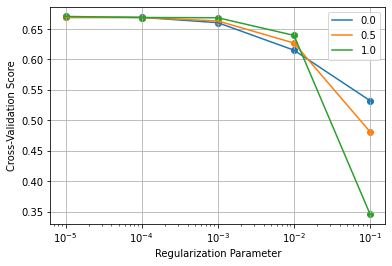

In [0]:
# plot cv
model_params = cv_model.getEstimatorParamMaps()

lr_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
  new_set = list(param_set.values()) + [acc]
  lr_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(lr_cv_summary_list,
                          columns=['reg_param', 'enet_param', 'acc'])
for en in cv_summary.enet_param.unique():
  sel = cv_summary.enet_param == en
  plt.plot(cv_summary.reg_param[sel], cv_summary.acc[sel], label=en)
  plt.scatter(cv_summary.reg_param[sel], cv_summary.acc[sel])

plt.legend()
plt.xscale('log')
plt.grid()
plt.xlabel('Regularization Parameter')
plt.ylabel('Cross-Validation Score')

plt.show()

## Part E: Hyperparameter Tuning for Decision Trees
Perform hyperparameter tuning for logistic regression. Start by using grid search and cross-validation to perform hyperparameter tuning for decision trees.

In [0]:
# create decision tree
dtree = DecisionTreeClassifier(featuresCol='features_dt', labelCol='Cover_Type', seed=1, maxBins=38)

# set params
param_grid = (ParamGridBuilder()
              .addGrid(dtree.maxDepth, [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24] )
              .addGrid(dtree.minInstancesPerNode, [1, 2, 4])
             ).build()

# create object to perform grid search
cv = CrossValidator(estimator=dtree, estimatorParamMaps=param_grid, numFolds=5, 
                    evaluator=accuracy_eval, seed=1)

# fit object to df
cv_model = cv.fit(train)

Identify the optimal model found by the grid search algorithm.

In [0]:
dt_model = cv_model.bestModel

# get best params
maxDepth = dt_model.getMaxDepth()
minInstancesPerNode = dt_model.getMinInstancesPerNode()

# output results
print('Max CV Score:   ', round(max(cv_model.avgMetrics),4))
print('Optimal Depth:  ', maxDepth)
print('Optimal MinInst:', minInstancesPerNode)

Max CV Score: 0.7775
Optimal Depth: 16
Optimal MinInst: 1

Generate a plot to display the results of the cross-validation.

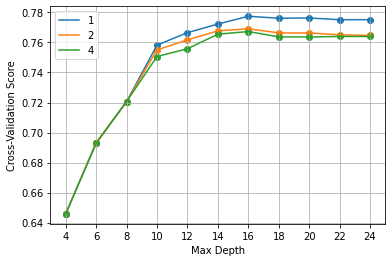

In [0]:
# plot cv
model_params = cv_model.getEstimatorParamMaps()

dt_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
  new_set = list(param_set.values()) + [acc]
  dt_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(dt_cv_summary_list,
                          columns=['maxDepth', 'minInst', 'acc'])
for mi in cv_summary.minInst.unique():
  sel = cv_summary.minInst == mi
  plt.plot(cv_summary.maxDepth[sel], cv_summary.acc[sel], label=mi)
  plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel])

plt.legend()
plt.grid()
plt.xticks(range(4,26,2))
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation Score')

plt.show()

Display the feature importance for the each of the features used in our optimal decision tree
model.

In [0]:
# get names and order of features in df
features = num_features + cat_features

pd.DataFrame({
    'feature':features,
    'importance':dt_model.featureImportances
})

Out[16]:

,feature,importance
0,Elevation,0.394260
1,Aspect,0.048116
2,Slope,0.026453
3,Horizontal_Distance_To_Hydrology,0.078278
4,Vertal_Distance_To_Hydrology,0.036748
5,Horizontal_Distance_To_Roadways,0.070875
6,Hillshade_9am,0.025840
7,Hillshade_Noon,0.023199
8,Hillshade_3pm,0.017314
9,Horizontal_Distance_To_Fire_Points,0.079365


## Part F: Identifying and Evaluating the Final Model
Determine which of these two models appears to have better performance on out-of-sample observations. Then test predictions and create a confusion matrix.

The decision tree model has a maximum cross validation score of 77.75%. The logistic regression model has a maximum cross validation score of 67.04%. Therefore, the decision tree model performs better on out-of-sample data and is selected as the final model.

Next, use the optimal model to generate predictions for the test set.

In [0]:
# generate predictions
test_pred = dt_model.transform(test)

# show first 10 rows
test_pred.select('probability', 'prediction', 'Cover_Type').show(10, truncate=False)

+------------------------------------------------------------------------------+----------+----------+
probability |prediction|Cover_Type|
+------------------------------------------------------------------------------+----------+----------+
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0] |6.0 |6 |
[0.0,0.0,0.0273972602739726,0.3150684931506849,0.0,0.0,0.6575342465753424,0.0]|6.0 |6 |
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0] |6.0 |6 |
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |3.0 |3 |
[0.0,0.0,0.0,0.09375,0.0,0.0,0.90625,0.0] |6.0 |6 |
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |3.0 |3 |
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |3.0 |6 |
[0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0] |3.0 |3 |
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0] |6.0 |3 |
[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0] |6.0 |6 |
+------------------------------------------------------------------------------+----------+----------+
only showing top 10 rows

Use the test predictions to evaluate the final model's performance on out-of-sample data.

In [0]:
# create pair RDD of prediction/label pairs
pred_and_labels = test_pred.rdd.map(lambda x:(x['prediction'],float(x['Cover_Type'])))

# get accuracy
metrics = MulticlassMetrics(pred_and_labels)
print(f'Test Set Accuracy: {metrics.accuracy}')

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(
Test Set Accuracy: 0.7818121252498335

Display the confusion matrix for the test data.

In [0]:
# extract confusion matrix
cm = metrics.confusionMatrix().toArray().astype(int)

# make df
pd.DataFrame(
    data=cm, 
    columns=range(1,8),
    index=range(1,8)
)

Out[19]:

,1,2,3,4,5,6,7
1,311,90,2,0,13,5,36
2,101,220,12,0,58,11,3
3,1,10,306,23,13,78,0
4,0,1,22,423,0,25,0
5,9,26,3,0,364,4,0
6,1,4,58,13,5,319,0
7,19,7,0,0,2,0,404


Observations in the test set with **Cover Type 2** were misclassified by the model as **Cover Type 1** a total of 101 times. This was the most common type of misclassification in the test set.

Next, display the precision and recall for all 7 label classes.

In [0]:
print('Label   Precision   Recall')
print('--------------------------')
for i, lab in enumerate(range(1,8)):
    print(f'{lab:<8}{metrics.precision(i+1):<12.4f}{metrics.recall(i+1):.4f}')

Label Precision Recall
--------------------------
1 0.7036 0.6805
2 0.6145 0.5432
3 0.7593 0.7100
4 0.9216 0.8981
5 0.8000 0.8966
6 0.7217 0.7975
7 0.9120 0.9352

1. The cover type most likely to be correctly classified by the final model is **Cover Type 7**.
2. The cover type most likely to be misclassified by the final model is **Cover Type 2**.
3. The cover type with the greatest difference between its precision and recall is **Cover Type 5**. There is a .0966 difference between the precision and recall. The precision is calculated as .8000. This means that the decision tree model will correctly predict the cover type as **Cover Type 5** 80% of the time. The recall is calculated as .8966. This means that, prior to the decision tree model's predictions, the model will correctly classify those with **Cover Type 5** 89.66% of the time.